In [1]:
import kagglehub
path = kagglehub.dataset_download("tanreinama/flicker8k-japanese-translation")

In [2]:
!pip install fugashi unidic-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 38.0 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.4/698.4 kB 23.8 MB/s eta 0:00:00
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658817 sha256=950b380939827b78ceaea77766cce1189856ce28b929f843830cef8f4f3bf1a6
  Stored in directory: /root/.cache/pip/wheels/b7/fd/e9/ea4459b868e6d2902e8d80e82dbacb6203e05b3b3a58c64966
Successfully built unidic-lite


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, metrics, losses, optimizers, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import pickle
from collections import Counter
from fugashi import Tagger
import unicodedata
import re
from nltk.translate.bleu_score import corpus_bleu
from transformers import MarianTokenizer, TFMarianMTModel, DataCollatorForSeq2Seq
from datasets import Dataset

2025-07-03 13:41:03.764159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751550063.996268      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751550064.061894      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
captions = pd.read_csv('/kaggle/input/flicker8k-japanese-translation/captions-ja.csv').dropna()
captions.head()

,image,caption,caption-ja
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,ピンクのドレスを着た子供が、入り口の階段を登っています。
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,木造の建物に入る少女。
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,木製のプレイハウスに登る少女。
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,階段を登ってプレイハウスに行く少女。
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,ピンクのドレスを着た少女が木の小屋に入る。


# Data Preprocessing

In [5]:
def tokenize_en(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", text)
    text = f"<start> {text} <end>"
    return text.strip().split()

tagger = Tagger()

def tokenize_ja(text):
    split = [token.surface for token in tagger(text.strip())]
    split.insert(0, '<start>')
    split.append('<end>')
    return split

captions['tokenize-en'] = captions['caption'].apply(tokenize_en)
captions['tokenize-ja'] = captions['caption-ja'].apply(tokenize_ja)

def decoderInput(text):
    return text[:-1]

def deocderOutput(text):
    return text[1:]

captions['tokenize-en-input'] = captions['tokenize-en'].apply(decoderInput)
captions['tokenize-en-target'] = captions['tokenize-en'].apply(deocderOutput)

In [6]:
def padSequences(input):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions[input])
    sequences = tokenizer.texts_to_sequences(captions[input])
    max_length = max([len(seq) for seq in sequences])
    padded_sequences = pad_sequences(sequences, maxlen = max_length, padding = 'post')
    vocab_size = len(tokenizer.word_index) + 1
    vocabulary = tokenizer.word_index
    return padded_sequences, max_length, vocab_size, vocabulary, tokenizer

In [7]:
padded_sequences_ja, max_length_ja, vocab_size_ja, vocabulary_ja, tokenizer_ja = padSequences(input = 'tokenize-ja')
padded_sequences_en_input, max_length_en_input, vocab_size_en_input, vocabulary_en_input, tokenizer_en_input = padSequences(input = 'tokenize-en-input')
padded_sequences_en_target, max_length_en_target, vocab_size_en_target, vocabulary_en_target, tokenizer_en_target = padSequences(input = 'tokenize-en-target')

# Train Test Split

In [8]:
encoder_inputs = np.array(padded_sequences_ja)
decoder_inputs = np.array(padded_sequences_en_input)
decoder_targets = np.array(padded_sequences_en_target)

encoder_train, encoder_test, decoder_train, decoder_test, decoder_target_train, decoder_target_test = train_test_split(
    encoder_inputs, decoder_inputs, decoder_targets, test_size = 0.2, random_state = 42
)

# Caption Translation | LSTM

In [20]:
def lstm_translation():

    encoder_input = layers.Input(shape = (max_length_ja, ))
    encoder_embedding = layers.Embedding(input_dim = vocab_size_ja, output_dim = 256)(encoder_input)
    encoder_lstm = layers.LSTM(256, return_state = True, return_sequences = True)
    encoder_output, encoder_hidden, encoder_cell = encoder_lstm(encoder_embedding)
    encoder_states = [encoder_hidden, encoder_cell]

    decoder_input = layers.Input(shape = (max_length_en_input, ))
    decoder_embedding = layers.Embedding(input_dim = vocab_size_en_input, output_dim = 256)(decoder_input)
    decoder_lstm = layers.LSTM(256, return_sequences = True)
    decoder_output = decoder_lstm(decoder_embedding, initial_state = encoder_states)
    decoder_dense = layers.Dense(vocab_size_en_input, activation = 'softmax')
    decoder_output = decoder_dense(decoder_output)

    model = Model([encoder_input, decoder_input], decoder_output)
    return model

In [22]:
model_lstm_translation = lstm_translation()

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
reduceLRONPlateau = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 1e-6, verbose = 1)
callbacks = [earlyStopping, reduceLRONPlateau]

optimizer = optimizers.Adam(learning_rate=1e-3, clipvalue = 1.0)
model_lstm_translation.compile(
    optimizer = optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history_lstm_translation = model_lstm_translation.fit([encoder_train, decoder_train], decoder_target_train,
                                                      epochs = 20, callbacks = callbacks, batch_size = 32,
                                                     validation_data = ([encoder_test, decoder_test], decoder_target_test))

model_lstm_translation.save('/kaggle/working/model_lstm_translation.keras')
with open('/kaggle/working/model_lstm_translation.pkl', 'wb') as f:
    pickle.dump(history_lstm_translation.history, f)

Epoch 1/20


I0000 00:00:1750899685.034166     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


1012/1012 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.7372 - loss: 1.9799 - val_accuracy: 0.7902 - val_loss: 1.1865 - learning_rate: 0.0010
Epoch 2/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.7952 - loss: 1.1321 - val_accuracy: 0.8089 - val_loss: 1.0412 - learning_rate: 0.0010
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.8176 - loss: 0.9653 - val_accuracy: 0.8296 - val_loss: 0.9062 - learning_rate: 0.0010
Epoch 4/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.8385 - loss: 0.8227 - val_accuracy: 0.8450 - val_loss: 0.8163 - learning_rate: 0.0010
Epoch 5/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.8535 - loss: 0.7183 - val_accuracy: 0.8544 - val_loss: 0.7582 - learning_rate: 0.0010
Epoch 6/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.8655 - loss: 0.6374 - val_accuracy: 0.8618 - val_loss: 0.7166 - learning_rate: 0.0010
Epoch 7/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.8760 

# Caption Translation | Encoder (GRU + BiLSTM) - Decoder(GRU + LSTM) + Additive Attention

In [35]:
def gru_lstm_addattention_translation():

    encoder_input = layers.Input(shape = (max_length_ja, ))
    encoder_embedding = layers.Embedding(input_dim = vocab_size_ja, output_dim = 256)(encoder_input)
    
    encoder_gru= layers.GRU(256, return_sequences = True)(encoder_embedding)
    encoder_bilstm = layers.Bidirectional(layers.LSTM(256, return_state = True, return_sequences = True))
    encoder_output, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_gru)

    state_h = layers.Concatenate()([forward_h, backward_h])
    state_c = layers.Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]

    decoder_input = layers.Input(shape = (max_length_en_input, ))
    decoder_embedding = layers.Embedding(input_dim = vocab_size_en_input, output_dim = 256)(decoder_input)
    
    decoder_gru = layers.GRU(256, return_sequences = True)(decoder_embedding)
    decoder_lstm = layers.LSTM(512, return_state = True, return_sequences = True)
    decoder_output, _, _ = decoder_lstm(decoder_gru, initial_state = encoder_states)
    
    
    attention = layers.AdditiveAttention()
    context_vector = attention([decoder_output, encoder_output])

    combined = layers.Concatenate(axis = -1)([decoder_output, context_vector])

    decoder_dense = layers.Dense(vocab_size_en_input, activation = 'softmax')
    final_output = decoder_dense(combined)

    model = Model([encoder_input, decoder_input], final_output)
    return model

In [36]:
model_gru_lstm_addattention_translation = gru_lstm_addattention_translation()

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
reduceLRONPlateau = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 1e-6, verbose = 1)
callbacks = [earlyStopping, reduceLRONPlateau]

optimizer = optimizers.Adam(learning_rate=1e-3, clipvalue = 1.0)
model_gru_lstm_addattention_translation.compile(
    optimizer = optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history_gru_lstm_addattention_translation = model_gru_lstm_addattention_translation.fit([encoder_train, decoder_train], decoder_target_train,
                                                      epochs = 20, callbacks = callbacks, batch_size = 32,
                                                     validation_data = ([encoder_test, decoder_test], decoder_target_test))

model_gru_lstm_addattention_translation.save('/kaggle/working/model_gru_lstm_addattention_translation.keras')
with open('/kaggle/working/model_gru_lstm_addattention_translation.pkl', 'wb') as f:
    pickle.dump(history_gru_lstm_addattention_translation.history, f)

Epoch 1/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 102s 94ms/step - accuracy: 0.7575 - loss: 1.6245 - val_accuracy: 0.8175 - val_loss: 0.9690 - learning_rate: 0.0010
Epoch 2/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 99s 97ms/step - accuracy: 0.8304 - loss: 0.8628 - val_accuracy: 0.8562 - val_loss: 0.7309 - learning_rate: 0.0010
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 99s 98ms/step - accuracy: 0.8684 - loss: 0.6007 - val_accuracy: 0.8814 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 4/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 99s 98ms/step - accuracy: 0.9000 - loss: 0.4072 - val_accuracy: 0.8955 - val_loss: 0.5122 - learning_rate: 0.0010
Epoch 5/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 99s 98ms/step - accuracy: 0.9266 - loss: 0.2748 - val_accuracy: 0.9023 - val_loss: 0.4829 - learning_rate: 0.0010
Epoch 6/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 99s 98ms/step - accuracy: 0.9447 - loss: 0.1976 - val_accuracy: 0.9051 - val_loss: 0.4735 - learning_rate: 0.0010
Epoch 7/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 99s 98ms/step - accur

# Caption Translation | MarianMT

In [40]:
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ja-en")

def preprocess(sample):
    inputs = tokenizer(sample['caption-ja'], max_length = 64, padding = 'max_length', truncation = True)
    targets = tokenizer(sample['caption'], max_length = 64, padding = 'max_length', truncation = True)
    inputs['labels'] = targets['input_ids']
    return inputs

dataset = Dataset.from_pandas(captions)
tokenized_dataset = dataset.map(preprocess)

split_dataset = tokenized_dataset.train_test_split(test_size = 0.2, seed = 42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

data_collactor = DataCollatorForSeq2Seq(tokenizer, model = None, return_tensors = "tf")

tf_train_dataset = train_dataset.to_tf_dataset(
    columns = ['input_ids', 'attention_mask', 'labels'],
    shuffle = True,
    batch_size = 32,
    collate_fn = data_collactor
)

tf_test_dataset = test_dataset.to_tf_dataset(
    columns = ['input_ids', 'attention_mask', 'labels'],
    shuffle = True,
    batch_size = 32,
    collate_fn = data_collactor
)

Map:   0%|          | 0/40455 [00:00<?, ? examples/s]

In [ ]:
MarianMT = TFMarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-ja-en")
MarianMT.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 3e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

history_MarianMT = MarianMT.fit(
    tf_train_dataset,
    epochs = 10,
    validation_data = tf_test_dataset
)

MarianMT.save_pretrained("MarianMT/")
tokenizer.save_pretrained("MarianMT/")
with open('/kaggle/working/MarianMT.pkl', 'wb') as f:
    pickle.dump(history_MarianMT.history, f)

# Load Models

In [9]:
model_lstm_translation = load_model('/kaggle/input/translation/other/default/1/captionTranslation/model_lstm_translation.keras')
with open('/kaggle/input/translation/other/default/1/captionTranslation/model_lstm_translation.pkl', 'rb') as f:
    history_lstm_translation = pickle.load(f)

model_gru_lstm_addattention_translation = load_model('/kaggle/input/translation/other/default/1/captionTranslation/model_gru_lstm_addattention_translation.keras')
with open('/kaggle/input/translation/other/default/1/captionTranslation/model_gru_lstm_addattention_translation.pkl', 'rb') as f:
    history_gru_lstm_addattention_translation = pickle.load(f)

MarianMT= TFMarianMTModel.from_pretrained("/kaggle/input/marianmtt/other/default/1/MarianMT/MarianMT")
Tokenizer = MarianTokenizer.from_pretrained("/kaggle/input/marianmtt/other/default/1/MarianMT/MarianMT")
with open('/kaggle/input/marianmtt/other/default/1/MarianMT/MarianMT.pkl', 'rb') as f:
    historyMarianMT = pickle.load(f)

I0000 00:00:1751550093.388548      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751550093.389376      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /kaggle/input/marianmtt/other/default/1/MarianMT/MarianMT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.
/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install 

# Visualize Metrics

In [17]:
def plotResults(history, model_name = 'Model'):
    metrics = ['accuracy', 'loss']
    val_metrics = ['val_accuracy', 'val_loss']

    epochs = range(1, len(history['loss']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(25, 5))

    for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
        ax = axes[i]
        ax.plot(epochs, history[metric], label=f'Train {metric}')
        ax.plot(epochs, history[val_metric], label=f'Val {metric}')
        ax.set_title(metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric)
        ax.legend()

    plt.suptitle(model_name, fontsize = 16)
    plt.tight_layout()
    plt.show()

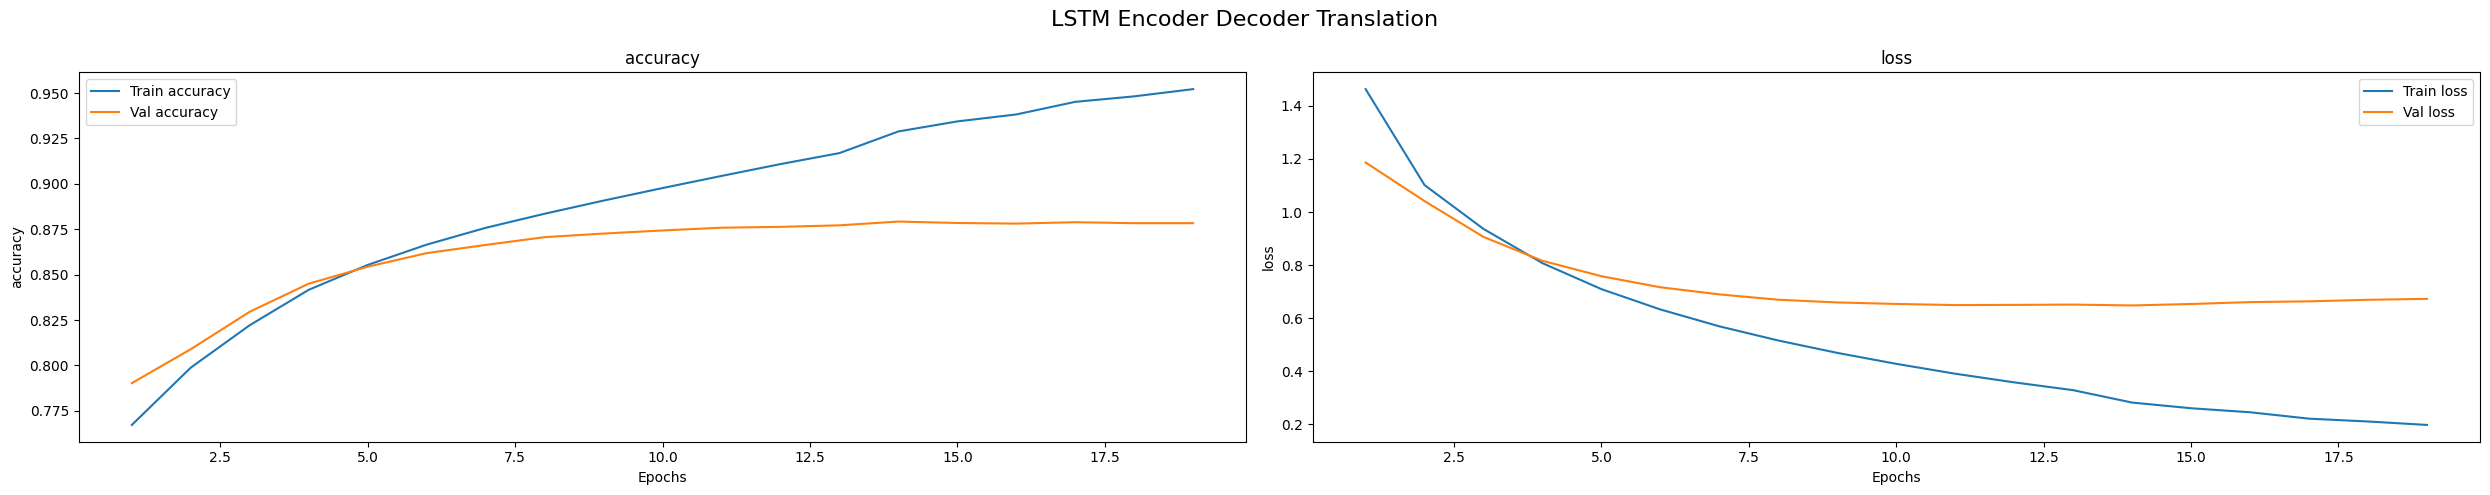

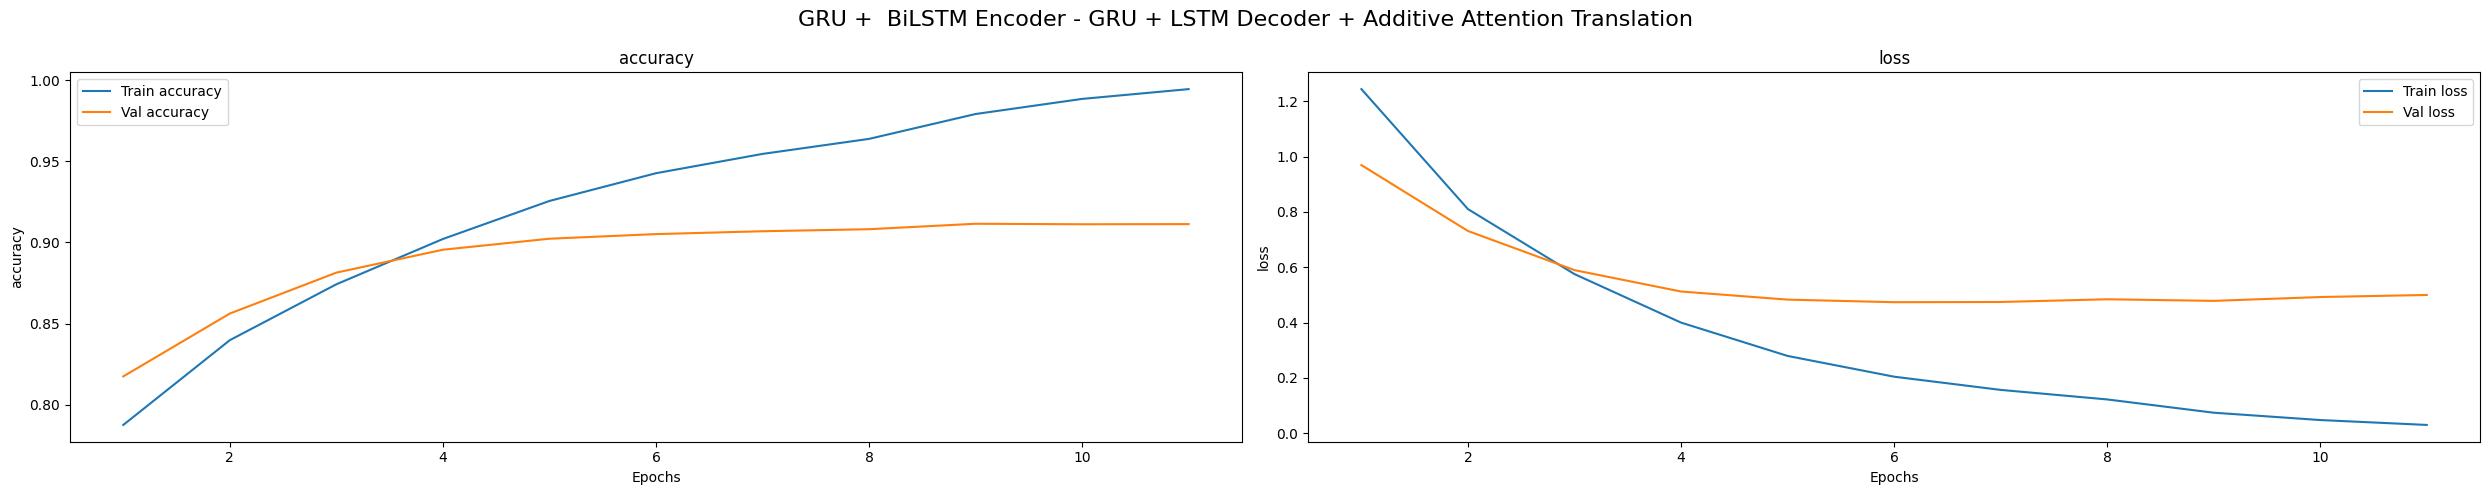

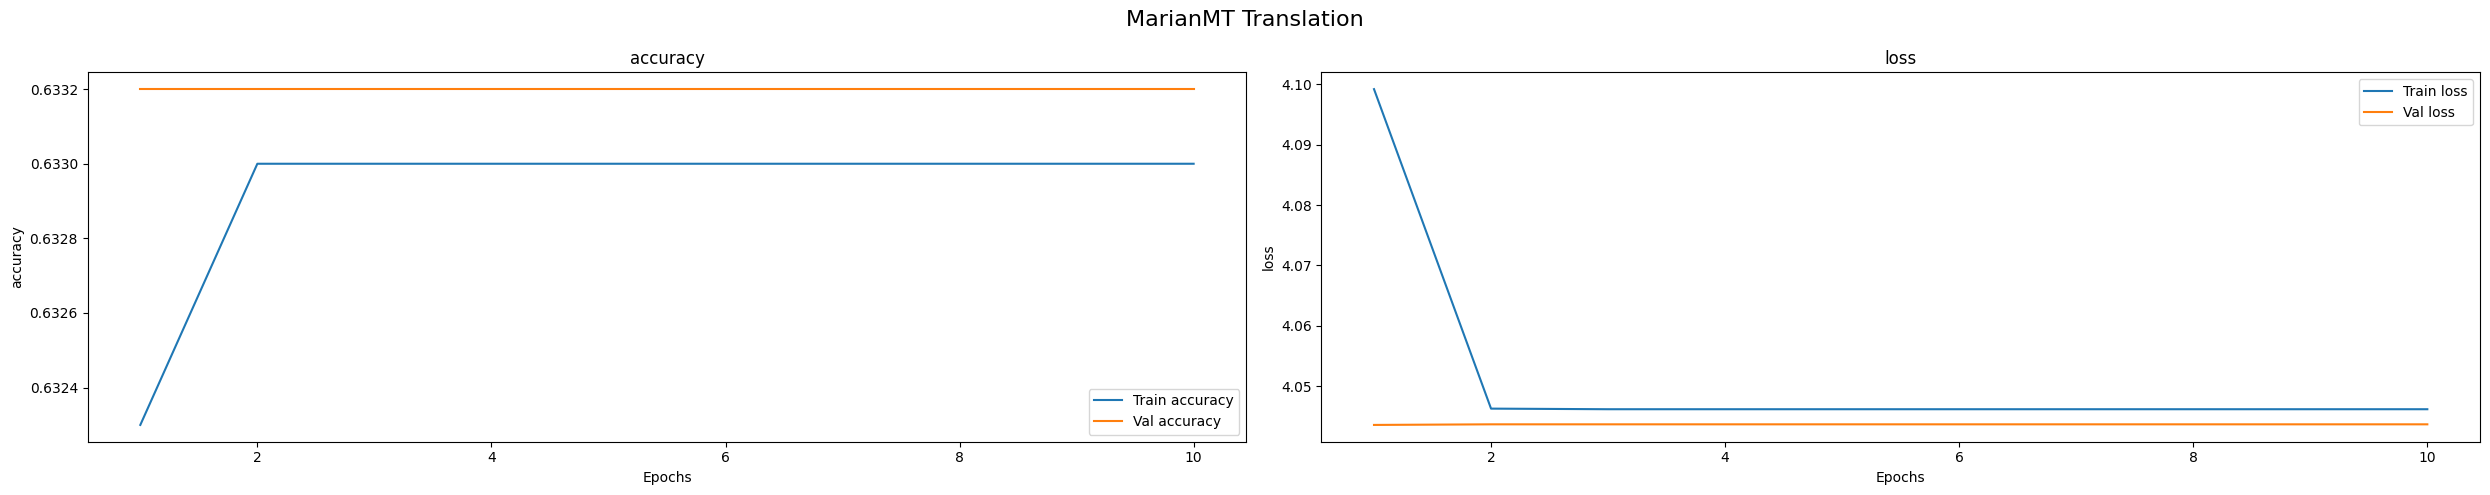

In [19]:
plotResults(history_lstm_translation, model_name = 'LSTM Encoder Decoder Translation')
plotResults(history_gru_lstm_addattention_translation, model_name = 'GRU +  BiLSTM Encoder - GRU + LSTM Decoder + Additive Attention Translation')
plotResults(historyMarianMT, model_name = 'MarianMT Translation')

# Evaluation

In [20]:
def computeBLUESCore(model, sample_size = 1000, model_name = 'model'):
    encoder_sample = encoder_test[:sample_size]
    decoder_target_sample = decoder_target_test[:sample_size]
    decoder_input_sample = decoder_test[:sample_size]

    predicted_probs = model.predict([encoder_sample, decoder_input_sample])
    predicted_ids = np.argmax(predicted_probs, axis=-1)

    def decode_sequence(seq, tokenizer):
        return [tokenizer.index_word.get(idx, "<unk>") for idx in seq if idx != 0]

    predicted_sentences = [decode_sequence(seq, tokenizer_en_target) for seq in predicted_ids]
    reference_sentences = [[decode_sequence(seq, tokenizer_en_target)] for seq in decoder_target_sample]

    bleu_score = corpus_bleu(reference_sentences, predicted_sentences)
    
    return (f"Corpus BLEU Score of {model_name} on {sample_size} samples: {round(bleu_score, 4)}")

In [21]:
translation_lstm_BLUE = computeBLUESCore(model_lstm_translation, model_name = 'LSTM Encoder Decoder Translation')
translation_gru_lstm_addattention_BLUE = computeBLUESCore(model_gru_lstm_addattention_translation, model_name = 'GRU +  BiLSTM Encoder - GRU + LSTM Decoder + Additive Attention Translation')
print(translation_lstm_BLUE)
print(translation_gru_lstm_addattention_BLUE)

 1/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

I0000 00:00:1751546251.252849     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
Corpus BLEU Score of LSTM Encoder Decoder Translation on 1000 samples: 0.3336
Corpus BLEU Score of GRU +  BiLSTM Encoder - GRU + LSTM Decoder + Additive Attention Translation on 1000 samples: 0.4468


In [22]:
print(f"Number of epochs before Early Stopping occur of LSTM Encoder Decoder Translation: {len(history_lstm_translation['loss'])}")
print(f"Number of epochs before Early Stopping occur of GRU +  BiLSTM Encoder - GRU + LSTM Decoder + Additive Attention Translation: {len(history_gru_lstm_addattention_translation['loss'])}")

Number of epochs before Early Stopping occur of LSTM Encoder Decoder Translation: 19
Number of epochs before Early Stopping occur of GRU +  BiLSTM Encoder - GRU + LSTM Decoder + Additive Attention Translation: 11


In [12]:
source_sentences = captions['caption-ja'][:100].tolist()
reference_sentences = captions['caption'][:100].tolist()

inputs = Tokenizer(source_sentences, return_tensors = "tf", padding = True, truncation = True)
logits = MarianMT.generate(**inputs, max_length=64, num_beams=4)
translated = Tokenizer.batch_decode(logits, skip_special_tokens=True)

bleu_score = corpus_bleu(reference_sentences, translated)
print(f"Corpus BLEU Score of MarianMT on 100 samples: {round(bleu_score, 4)}")

Corpus BLEU Score of MarianMT on 100 samples: 0.0


# Inference

In [16]:
def translate(input_text, model):
    tokenized_input = tokenize_ja(input_text)
    input_sequence = tokenizer_ja.texts_to_sequences([tokenized_input])
    input_sequence = pad_sequences(input_sequence, maxlen=max_length_ja, padding='post')
    
    decoder_input = np.zeros((1, max_length_en_input))
    decoder_input[0, 0] = tokenizer_en_input.word_index['<start>']
    
    translated_sentence = []
    for i in range(max_length_en_input - 1):
        output = model.predict([input_sequence, decoder_input], verbose = 0)
        predicted_token_index = np.argmax(output[0, i, :])
        
        if predicted_token_index == tokenizer_en_target.word_index['<end>']:
            break

        predicted_word = tokenizer_en_input.index_word[predicted_token_index]
        translated_sentence.append(predicted_word)

        decoder_input[0, i+1] = predicted_token_index

    return ' '.join(translated_sentence)

In [17]:
inferences = [
    "男の子が青いシャツを着て遊んでいる。",
    "若い男性が公園で走っている。",
    "少女が犬と一緒に草原を走っている。",
    "年配の男性がカメラで景色を撮っている。",
    "女性が晴れた日に凧をあげている。"
]

In [20]:
for sentence in inferences:
    translated = translate(sentence, model_lstm_translation)
    print(f"Input (Japanese): {sentence}")
    print(f"Translation (English): {translated}")
    print()

Input (Japanese): 男の子が青いシャツを着て遊んでいる。
Translation (English): a boy is wearing a blue shirt playing .

Input (Japanese): 若い男性が公園で走っている。
Translation (English): a young man is playing a game of people .

Input (Japanese): 少女が犬と一緒に草原を走っている。
Translation (English): a girl is running through a field of grass with a dog .

Input (Japanese): 年配の男性がカメラで景色を撮っている。
Translation (English): an older man is walking past a table .

Input (Japanese): 女性が晴れた日に凧をあげている。
Translation (English): a woman is kayaking down a river .



In [21]:
for sentence in inferences:
    translated = translate(sentence, model_gru_lstm_addattention_translation)
    print(f"Input (Japanese): {sentence}")
    print(f"Translation (English): {translated}")
    print()

Input (Japanese): 男の子が青いシャツを着て遊んでいる。
Translation (English): a boy is playing with a blue shirt .

Input (Japanese): 若い男性が公園で走っている。
Translation (English): a young man is running in a park .

Input (Japanese): 少女が犬と一緒に草原を走っている。
Translation (English): a girl is running through a field with a dog .

Input (Japanese): 年配の男性がカメラで景色を撮っている。
Translation (English): an older man is taking a picture with his camera .

Input (Japanese): 女性が晴れた日に凧をあげている。
Translation (English): a woman is spinning a hot day on a sunny day .



In [29]:
for sentence in inferences:
    inputs = Tokenizer(sentence, return_tensors = "tf", padding = True, truncation = True)
    logits = MarianMT.generate(**inputs, max_length=64, num_beams=4)
    translated = Tokenizer.batch_decode(logits, skip_special_tokens=True)
    print(f"Input (Japanese): {sentence}")
    print(f"Translation (English): {translated[0]}")
    print()

Input (Japanese): 男の子が青いシャツを着て遊んでいる。
Translation (English): I don't know, I just don't know, I just don't know, I just don't know.

Input (Japanese): 若い男性が公園で走っている。
Translation (English): I've never really been that way. I just don't feel that I'm being that way. I just feel really, really, really, really, really, really, really, really, really, really, really, really, really, really, really, really, really, really,

Input (Japanese): 少女が犬と一緒に草原を走っている。
Translation (English): I've never been so happy. I've never really been so happy.

Input (Japanese): 年配の男性がカメラで景色を撮っている。
Translation (English): I've never really been that way. I just don't feel that I'm a good person.

Input (Japanese): 女性が晴れた日に凧をあげている。
Translation (English): I've never really been that way. I've always been a bit more than that. I've never really been that way.

